In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.metrics import roc_curve, auc

In [63]:
# -------------------------------
# 1. Load data
# -------------------------------
file="/content/drive/MyDrive/data.csv" #replace with file path
cancer_data = pd.read_csv(file)


In [53]:
# -------------------------------
# 2. Convert diagnosis labels: B -> 0, M -> 1
# -------------------------------
cancer_data.loc[cancer_data["diagnosis"] == "B", "diagnosis"] = 0
cancer_data.loc[cancer_data["diagnosis"] == "M", "diagnosis"] = 1
cancer_data["diagnosis"] = cancer_data["diagnosis"].astype(int)

# Then split into alldata dictionary
alldata = {diag: df for diag, df in cancer_data.groupby("diagnosis")}


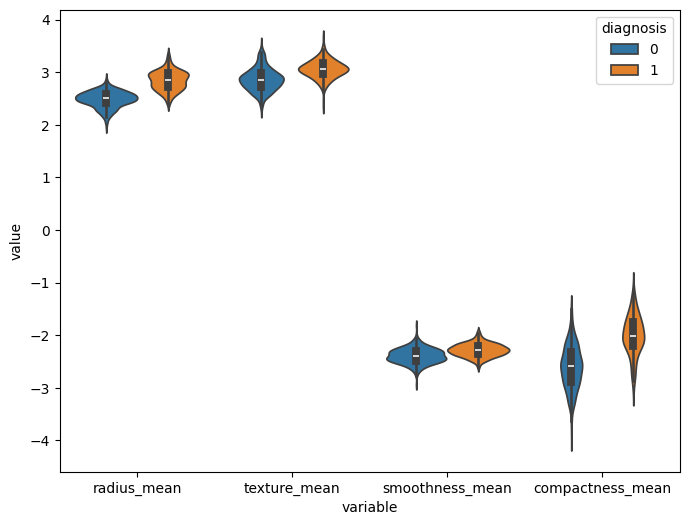

In [54]:
# -------------------------------
# 3. Melt for violin plots
# -------------------------------
cancer_melt = cancer_data.melt(id_vars=["id", "diagnosis"])
cancer_melt_filter = cancer_melt[
    cancer_melt["variable"].isin([
        "radius_mean",
        "texture_mean",
        "smoothness_mean",
        "compactness_mean"
    ])
]

plt.figure(figsize=(8,6))
sns.violinplot(
    data=cancer_melt_filter.assign(value=np.log(cancer_melt_filter["value"])),
    x="variable",
    y="value",
    hue="diagnosis"
)
plt.show()

In [59]:
# -------------------------------
# 4. Split into training and test sets (matching R)
# -------------------------------
# Group by diagnosis
alldata = {diag: df for diag, df in cancer_data.groupby("diagnosis")}

# Random sampling (same numbers as R)
np.random.seed(42)  # for reproducibility
randomMal = np.random.choice(alldata[1].index, 40, replace=False)
randomBen = np.random.choice(alldata[0].index, 70, replace=False)

# Training set: drop random indices
cancer_training = pd.concat([
    alldata[1].drop(randomMal),
    alldata[0].drop(randomBen)
])

# Test set: only random indices
cancer_test = pd.concat([
    alldata[1].loc[randomMal],
    alldata[0].loc[randomBen]
])

cancer_training["diagnosis"] = cancer_training["diagnosis"].astype(int)
cancer_test["diagnosis"] = cancer_test["diagnosis"].astype(int)


In [60]:
# -------------------------------
# 5. Fit single-feature logistic regressions
# -------------------------------
import statsmodels.api as sm
features = ["radius_mean", "texture_mean", "smoothness_mean", "compactness_mean"]
models = {}

for feature in features:
    models[feature] = smf.glm(
    formula=f"diagnosis ~ {feature}",
    data=cancer_training,
    family=sm.families.Binomial()
    ).fit()



In [61]:
# -------------------------------
# 6. Fit full model
# -------------------------------
cancer_glm_all = smf.glm(
    "diagnosis ~ radius_mean + compactness_mean + smoothness_mean + texture_mean",
    data=cancer_training,
    family=sm.families.Binomial()
).fit()


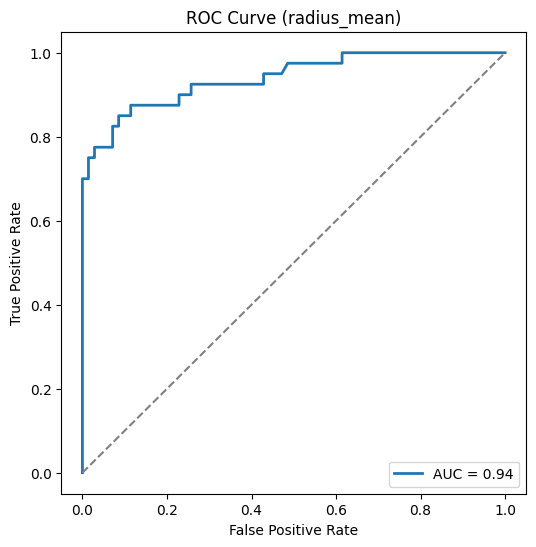

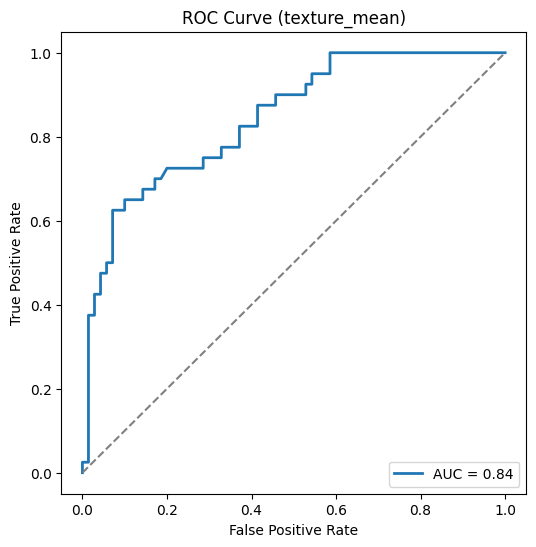

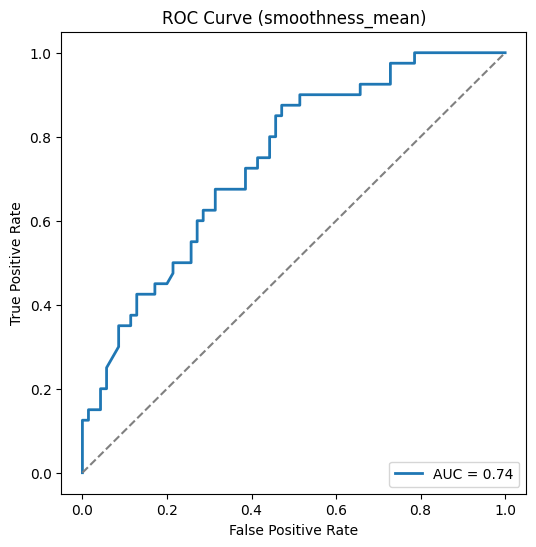

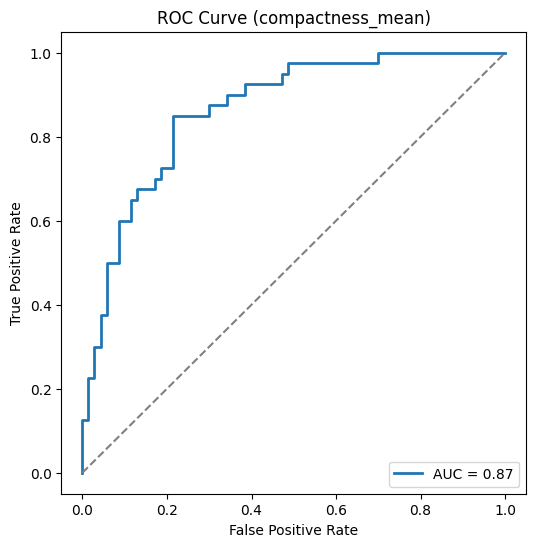

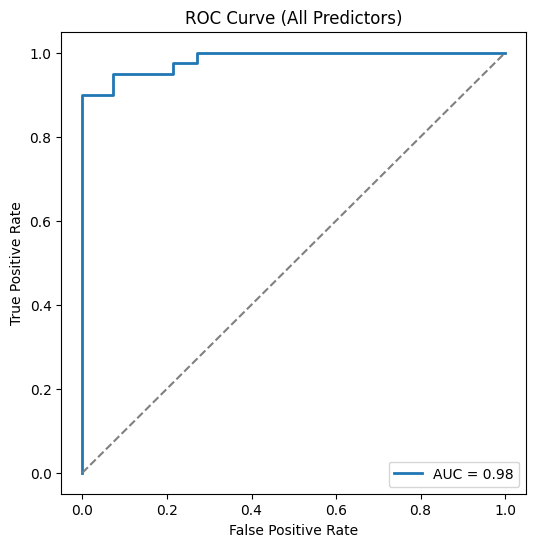

(33     0.999916
 400    0.999963
 274    0.986646
 129    0.999953
 87     0.999081
          ...   
 276    0.000401
 111    0.156703
 157    0.517614
 106    0.052166
 160    0.088761
 Length: 110, dtype: float64,
 np.float64(0.9842857142857143))

In [62]:
# -------------------------------
# 7. Predictions and ROC/AUC function
# -------------------------------
def plot_roc(model, feature_name):
    y_true = cancer_test["diagnosis"].astype(int)
    y_pred = model.predict(cancer_test)

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({feature_name})')
    plt.legend(loc="lower right")
    plt.show()

    return y_pred, roc_auc

# Plot ROC for single-feature models
for feature in features:
    plot_roc(models[feature], feature)

# Plot ROC for full model
plot_roc(cancer_glm_all, "All Predictors")